##Exploring several ways to understand the data##

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in

import sys
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt # plotting
import seaborn as sns
import itertools
%matplotlib inline
sns.set(style="whitegrid")

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

from subprocess import check_output
print(check_output(["ls", "../input"]).decode("utf8"))

# Any results you write to the current directory are saved as output.

train.h5



In [2]:
import kagglegym

env = kagglegym.make()

# get the reference to the api
observation = env.reset()

In [3]:
with pd.HDFStore('../input/train.h5') as train:
    df = train.get('train')

Opening ../input/train.h5 in read-only mode


In [5]:
train = df.copy(deep = True)
ID = "id"
TSTAMP = "timestamp"
TARGET = "y"
print("There are {} rows and {} columns in the dataset".format(*train.shape))

There are 1710756 rows and 111 columns in the dataset


 **Let us divide the columns according to the prefixes**

In [6]:
def findMatchedColumnsUsingPrefix(prefix, df):
    columns = df.columns[df.columns.str.startswith(prefix)]
    return list(columns.values)

In [7]:
derived_columns = findMatchedColumnsUsingPrefix("derived", train)
fundamental_columns = findMatchedColumnsUsingPrefix("fundamental", train)
technical_columns = findMatchedColumnsUsingPrefix("technical", train)

print("There are {} derived columns".format(len(derived_columns)))
print("There are {} fundamental columns".format(len(fundamental_columns)))
print("There are {} technical columns".format(len(technical_columns)))

There are 5 derived columns
There are 63 fundamental columns
There are 40 technical columns


In [8]:
ids = train[ID].unique()
tstamps = train[TSTAMP].unique()

**This function calculates the number of missing records within an asset for the group of columns passes as a reference**

In [9]:
def findMissingEntriesForIds(columns, train, identifier):
    indexes = []
    
    # prepare the header
    rows = {}
    rows['id'] = []
    for column in columns:
        rows[column] = []
        
    # count number of missing entries in a column for an id group
    for id, group in train.groupby(identifier):
        rows['id'].append(id)
        for column in columns:
            rows[column].append(pd.isnull(group[column]).sum())
            
    df = pd.DataFrame(rows)
    #df.columns = pd.MultiIndex.from_tuples([tuple(c.split('_')) for c in df.columns])
    #df = df.stack(0).reset_index(1)
    #df.sort_index()
    return df

**Calculates count of missing records for derived columns group by assets**

In [10]:
derived = findMissingEntriesForIds(derived_columns, train, ID)
derived.head(2)

,derived_0,derived_1,derived_2,derived_3,derived_4,id
0,3,3,3,3,3,0
1,4,4,4,4,4,6


**Calculates count of missing records for fundamental columns group by assets**

In [11]:
fundamental = findMissingEntriesForIds(fundamental_columns, train, ID)
fundamental.head(2)

,fundamental_0,fundamental_1,fundamental_10,fundamental_11,fundamental_12,fundamental_13,fundamental_14,fundamental_15,fundamental_16,fundamental_17,...,fundamental_59,fundamental_6,fundamental_60,fundamental_61,fundamental_62,fundamental_63,fundamental_7,fundamental_8,fundamental_9,id
0,3,123,3,3,3,3,3,3,3,3,...,3,3,3,123,3,938,3,3,3,0
1,4,728,728,4,4,4,4,4,4,4,...,4,728,4,728,728,4,4,4,4,6


**Calculates count of missing records for technical columns group by assets**

In [12]:
technical = findMissingEntriesForIds(technical_columns, train, ID)
technical.head(2)

,id,technical_0,technical_1,technical_10,technical_11,technical_12,technical_13,technical_14,technical_16,technical_17,...,technical_39,technical_40,technical_41,technical_42,technical_43,technical_44,technical_5,technical_6,technical_7,technical_9
0,0,3,103,3,3,3,8,3,3,3,...,3,3,42,3,3,182,122,3,3,3
1,6,4,101,4,4,4,7,4,4,4,...,4,4,39,4,4,184,122,4,4,4


**Find total count of missing entries for each column**

In [13]:
def calculateColumnSum(res, columns):
    names = []
    values = []
    for column in columns:
        names.append(column)
        values.append(res[column].sum())
    data = pd.DataFrame({'columns' : names, 'counts' : values})
    data = data.sort_values(by=['counts'], ascending = False)
    return data

In [14]:
def createHorizontalBarPlot(labels, missing, plot_width, plot_height, width, title):
    N = len(labels)
    ind = np.arange(N)
    fig, ax = plt.subplots(figsize = (plot_width, plot_height))
    rects = ax.barh(ind, missing, width)
    ax.set_yticks(ind + width / 2)
    ax.set_yticklabels(labels)
    ax.set_title(title)
    plt.show()
    plt.close()

The columns with minimum null is derived_0
The columns with maximum null is derived_4


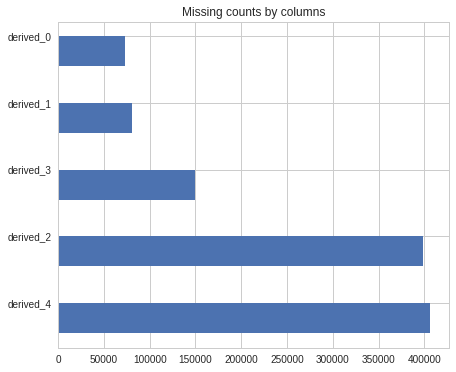

In [15]:
result = calculateColumnSum(derived, derived_columns)
print("The columns with minimum null is {}".format(result.iloc[-1]['columns']))
print("The columns with maximum null is {}".format(result.iloc[0]['columns']))

createHorizontalBarPlot(result['columns'], result['counts'], 7, 6, 0.45, 'Missing counts by columns')

The columns with minimum null is fundamental_33
The columns with maximum null is fundamental_5


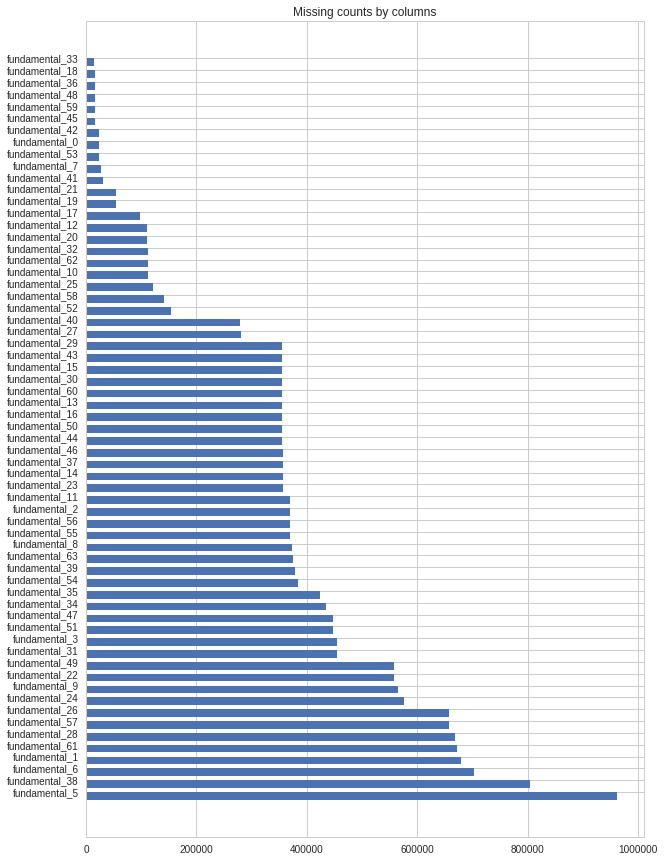

In [16]:
result = calculateColumnSum(fundamental, fundamental_columns)
print("The columns with minimum null is {}".format(result.iloc[-1]['columns']))
print("The columns with maximum null is {}".format(result.iloc[0]['columns']))

createHorizontalBarPlot(result['columns'], result['counts'], 10, 15, 0.65, 'Missing counts by columns')

The columns with minimum null is technical_22
The columns with maximum null is technical_28


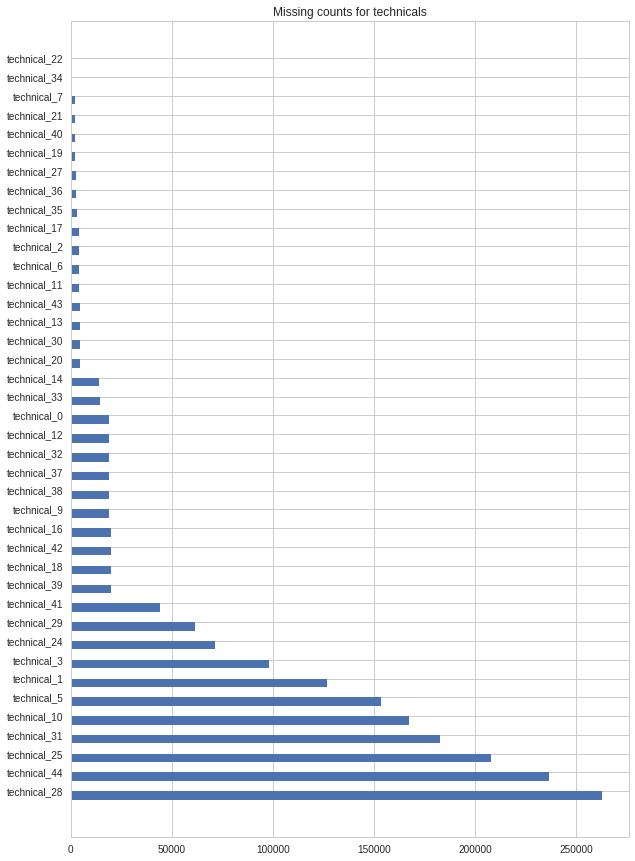

In [17]:
result = calculateColumnSum(technical, technical_columns)
print("The columns with minimum null is {}".format(result.iloc[-1]['columns']))
print("The columns with maximum null is {}".format(result.iloc[0]['columns']))

createHorizontalBarPlot(result['columns'], result['counts'], 10, 15, 0.45, 'Missing counts for technicals')

**Join the frames of missing records counts for all columns**

In [18]:
merged = derived.merge(fundamental, how = 'inner', on = 'id')
merged = merged.merge(technical, how = 'inner', on = 'id')
merged.head(2)

,derived_0,derived_1,derived_2,derived_3,derived_4,id,fundamental_0,fundamental_1,fundamental_10,fundamental_11,...,technical_39,technical_40,technical_41,technical_42,technical_43,technical_44,technical_5,technical_6,technical_7,technical_9
0,3,3,3,3,3,0,3,123,3,3,...,3,3,42,3,3,182,122,3,3,3
1,4,4,4,4,4,6,4,728,728,4,...,4,4,39,4,4,184,122,4,4,4


**Add a new column sum which calculates count of missing records for an asset across all columns**

In [19]:
copy = merged.copy(deep = True)
copy['sum'] = copy.apply(lambda x : x.sum(), axis = 1)
copy = copy.sort_values(by='sum', ascending = True)
result = copy[['id', 'sum']]
result.head(2)

,id,sum
289,435,647
182,277,961


In [21]:
print("The asset with minimum missing records for all columns = {}".format(result.iloc[0][ID]))
print("The asset with maximum missing records for all columns = {}".format(result.iloc[-1][ID]))

The asset with minimum missing records for all columns = 435
The asset with maximum missing records for all columns = 288


**This chart prints the top x assets with minimum missing records**

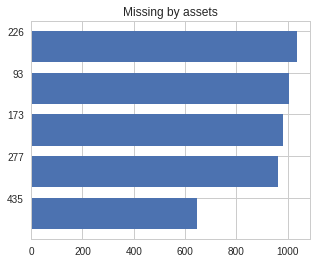

In [20]:
plot_df = result[:5]
createHorizontalBarPlot(plot_df['id'], plot_df['sum'], 5, 4, 0.75, 'Missing by assets')

**This chart prints the top x assets with maximum missing records**

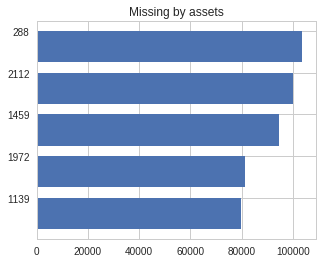

In [22]:
plot_df = result.tail(5)
createHorizontalBarPlot(plot_df['id'], plot_df['sum'], 5, 4, 0.75, 'Missing by assets')

**This function calculates the timestamps where data is missing for an asset**

In [23]:
def getTstampForMissingRecordsInColumn(df, columns, identifier):
    records = []
    for id, group in df.groupby(identifier):
        group_index_dict = {}
        group_index_dict[identifier] = id
        for col in columns:
            group_index_dict[col] = list(group[pd.isnull(group[col])][TSTAMP])
        records.append(group_index_dict)
    return records

**Execute the above function for derived columns**

In [24]:
missing_tstamps = getTstampForMissingRecordsInColumn(train, derived_columns, ID)
missing_tstamps[:1]

[{'derived_0': [167, 168, 169],
  'derived_1': [167, 168, 169],
  'derived_2': [167, 168, 169],
  'derived_3': [167, 168, 169],
  'derived_4': [167, 168, 169],
  'id': 0}]

**From the result of the above function we calculate the difference between the maximum and the minimum timestamp to determine if they are consecutive in nature**

In [25]:
def findTstampDiffForMissingRecordsByID(tstamp_indices):
    rows = []
    for item in tstamp_indices:
        row_dict = {}
        for key, value in item.items():
            if key == 'id':
                row_dict[key] = value
            else:
                row_dict[key] = int((value[-1] - value[0] + 1) / len(value)) if len(value) > 1 else len(value)
        rows.append(row_dict)

    return pd.DataFrame(rows)

In [26]:
tstamp_diff_df = findTstampDiffForMissingRecordsByID(missing_tstamps)
tstamp_diff_df.head(2)

,derived_0,derived_1,derived_2,derived_3,derived_4,id
0,1,1,1,1,1,0
1,1,1,1,1,1,6


***1* - The timestamps for the missing entries are in succession.</br>**

***0* - There are no missing records.</br>**

***Anything besides 1 and 0 means that the timestamps are not in succession, some entries are there between the missing values.***

**This function brings out those columns with non-consecutive missing timestamps.**

In [27]:
def findColumnsWithNonConsecutiveMissingTstampDiff(columns, tstamp_diff_dataframe):
    columns_with_discrete_missing_tstamps = {}
    
    for column in columns:
        unique_arr = list(tstamp_diff_dataframe[column].unique())
        temp = [i for i in unique_arr if i not in [1, 0]]
        if len(temp) > 0:
            columns_with_discrete_missing_tstamps[column] = temp
        
    return columns_with_discrete_missing_tstamps

In [28]:
tstamp_diff_dict = findColumnsWithNonConsecutiveMissingTstampDiff(derived_columns, tstamp_diff_df)
tstamp_diff_dict

{'derived_0': [2],
 'derived_1': [2],
 'derived_2': [2],
 'derived_3': [2],
 'derived_4': [2]}

**Determine the identifiers where the missing timestamps are not in succession**

In [29]:
def findAssetsWithNonConsecutiveMissingTstamp(discrete_missing_tstamp_diff_dict, tstamp_diff_data):
    assets_with_discrete_missing_tstamps = []
    
    for key, values in discrete_missing_tstamp_diff_dict.items():
        data = tstamp_diff_data.ix[tstamp_diff_data[key].isin(values)]
        assets_with_discrete_missing_tstamps += list(data[ID].values)
    
    return list(set(assets_with_discrete_missing_tstamps))

In [30]:
id_with_discrete_missing_tstamp = findAssetsWithNonConsecutiveMissingTstamp(tstamp_diff_dict, tstamp_diff_df)
id_with_discrete_missing_tstamp

[1950]

In [31]:
missing_tstamps = getTstampForMissingRecordsInColumn(train, fundamental_columns, ID)
tstamp_diff_df = findTstampDiffForMissingRecordsByID(missing_tstamps)

tstamp_diff_dict = findColumnsWithNonConsecutiveMissingTstampDiff(fundamental_columns, tstamp_diff_df)
id_with_discrete_missing_tstamp += findAssetsWithNonConsecutiveMissingTstamp(tstamp_diff_dict, tstamp_diff_df)
id_with_discrete_missing_tstamp = list(set(id_with_discrete_missing_tstamp))
id_with_discrete_missing_tstamp

[1950]

In [32]:
missing_indices = getTstampForMissingRecordsInColumn(train, technical_columns, ID)
tstamp_diff_df = findTstampDiffForMissingRecordsByID(missing_indices)

tstamp_diff_dict = findColumnsWithNonConsecutiveMissingTstampDiff(technical_columns, tstamp_diff_df)
id_with_discrete_missing_tstamp += findAssetsWithNonConsecutiveMissingTstamp(tstamp_diff_dict, tstamp_diff_df)
id_with_discrete_missing_tstamp = list(set(id_with_discrete_missing_tstamp))
id_with_discrete_missing_tstamp

[1950]

In [33]:
print("The assets with missing entries that are not consecutive is {}".format(id_with_discrete_missing_tstamp))

The assets with missing entries that are not consecutive is [1950]


In [34]:
def barplot(res, width, index, column):
    N = int(res.shape[0])
    fig, ax = plt.subplots(figsize = (2, 1))
    ind = np.arange(N)
    rects = plt.bar(res['diff'], res['size'])
    ax.set_title(column)
    ax.set_xticks(ind + width / 2)
    ax.set_xticklabels(res['diff'])
    plt.show()

## Calculate statistics ##

In [35]:
def calculate_statistics(data, columns, identifier, excludes):
    rows = {}
    rows[identifier] = []

    min = {}
    max = {}
    sum = {}
    mean = {}
    median = {}
    std = {}
    total = {}
    null_counts = {}
    non_null_counts = {}
    
    for column in columns:
        if column in excludes:
            continue
        min[column + '-' + 'min'] = []
        max[column + '-' + 'max'] = []
        sum[column + '-' + 'sum'] = []
        mean[column + '-' + 'mean'] = []
        median[column + '-' + 'median'] = []
        std[column + '-' + 'std'] = []
        total[column + '-' + 'total'] = []
        non_null_counts[column+ '-' + 'non_null'] = []

    for id, group in train.groupby(identifier):
        rows[identifier].append(id)
        
        for column in columns:
            if column in excludes:
                continue
            min[column + '-' + 'min'].append(group[column].dropna().min())
            max[column + '-' + 'max'].append(group[column].max())
            sum[column + '-' + 'sum'].append(group[column].sum())
            mean[column + '-' + 'mean'].append(group[column].mean())
            median[column + '-' + 'median'].append(group[column].median())
            std[column + '-' + 'std'].append(group[column].std())
            total[column + '-' + 'total'].append(group[column].shape[0])
            non_null_counts[column+ '-' + 'non_null'].append(pd.notnull(group[column]).sum())

    records = {} 
    records['id'] = rows['id']
    for feature in [min, max, mean, median, sum, std, total, non_null_counts]:
        for key, values in feature.items():
            records[key] = values
            
    stats_df = pd.DataFrame(records)        
    stats_df.columns = pd.MultiIndex.from_tuples([tuple(c.split('-')) for c in stats_df.columns])
    stats_df = stats_df.set_index('id')
    stats_df = stats_df.stack(0).reset_index(1)
    return stats_df

In [38]:
stats_df_der = calculate_statistics(train, derived_columns , 'id', ['id, timestamp', 'y'])
stats_df_der.head(1)

,level_1,max,mean,median,min,non_null,std,sum,total
id,,,,,,,,,
0,derived_0,0.473889,0.007053,-0.064533,-0.42743,1643,0.272028,11.587509,1646


In [39]:
stats_df_fund = calculate_statistics(train, fundamental_columns , 'id', ['id, timestamp', 'y'])
stats_df_fund.head(1)

,level_1,max,mean,median,min,non_null,std,sum,total
id,,,,,,,,,
0,fundamental_0,-0.02465,-0.182882,-0.182136,-0.38016,1643,0.073751,-300.475677,1646


In [40]:
stats_df_tech = calculate_statistics(train, technical_columns , 'id', ['id, timestamp', 'y'])
stats_df_tech.head(1)

,level_1,max,mean,median,min,non_null,std,sum,total
id,,,,,,,,,
0,technical_0,0.0,-0.171782,-0.001069,-0.99986,1643,0.303531,-282.237366,1646


**Find the total percentage of records present in each column**

In [41]:
def get_total_count_of_occurring_records(column_name, column_values, data, order_dict):
    
    header_dict = {}
    header_dict[column_name] = []
    header_dict['total_present'] = []
    header_dict['total'] = []
    
    for value in column_values:
        df = data.loc[data[column_name] == value]
        header_dict[column_name].append(value)
        non_nulls = len(list(df.loc[df['non_null'] > 0].index))
        header_dict['total_present'].append(non_nulls)
        header_dict['total'].append(len(df.index))
    
    result = pd.DataFrame(header_dict)
    ordered_column = next(iter(order_dict.keys()))
    order = next(iter(order_dict.values()))
    result = result.sort_values(by = ordered_column, ascending = order)
    return result

**Execute the above function for derived columns**

In [42]:
percentage_df = get_total_count_of_occurring_records('level_1', derived_columns, stats_df_der, {'total_present' : False})
percentage_df['percentage'] = (percentage_df['total_present'] / percentage_df['total']) * 100
percentage_df

,level_1,total,total_present,percentage
0,derived_0,1424,1338,93.960674
1,derived_1,1424,1335,93.750000
3,derived_3,1424,1273,89.396067
2,derived_2,1424,1086,76.264045
4,derived_4,1424,1069,75.070225


In [44]:
percentage_df = get_total_count_of_occurring_records('level_1', fundamental_columns, stats_df_fund, {'total_present' : False})
percentage_df['percentage'] = (percentage_df['total_present'] / percentage_df['total']) * 100
percentage_df.head(2)

,level_1,total,total_present,percentage
58,fundamental_59,1424,1407,98.80618
44,fundamental_45,1424,1407,98.80618


In [45]:
percentage_df = get_total_count_of_occurring_records('level_1', technical_columns, stats_df_tech, {'total_present' : False})
percentage_df['percentage'] = (percentage_df['total_present'] / percentage_df['total']) * 100
percentage_df.head(2)

,level_1,total,total_present,percentage
29,technical_34,1424,1424,100.0
19,technical_22,1424,1424,100.0


## Calculate the assets with missing values ##

In [46]:
def get_assets_with_missing(columns, stats_df):
    result = {}
    for column in columns:
        missing_ids_df = stats_df.loc[stats_df['level_1'] == column]
        missing_ids_df = missing_ids_df.loc[missing_ids_df['non_null'] == 0]
        result[column] = list(missing_ids_df.index)
       
    return result

In [47]:
der_missing_assets = get_assets_with_missing(derived_columns, stats_df_der)
fun_missing_assets = get_assets_with_missing(fundamental_columns, stats_df_fund)
tech_missing_assets = get_assets_with_missing(technical_columns, stats_df_tech)

**Calculate maximum and minimum asset and its value from the statistics dataframe**

In [48]:
def calculate_maxmin_id_and_value_from_stats(dataframe, field_name, field_values, feature_values):
    
    data_copy = dataframe.copy(deep = True)
    
    headers = list(itertools.product(field_values, feature_values))
    headers = [":".join(item) for item in headers]
    headers = list(itertools.product(headers, ['high', 'low', 'highid', 'lowid']))
    headers = ["-".join(item) for item in headers]
    
    columns_dict = {}
    for item in headers:
        columns_dict[item] = []
    
    for key in columns_dict:
        stats_column = key.split('-')[0]
        feature_to_find = key.split('-')[1]
        original_column = stats_column.split(':')[0]
        stats_feature = stats_column.split(':')[1]
        
        temp = data_copy.loc[data_copy[field_name] == original_column]
        temp = temp.sort_values(by=stats_feature, ascending = False)
        temp = temp[[stats_feature]]
        temp = temp.reset_index()
        
        if feature_to_find == 'high':
            columns_dict[key].append(temp.head(1)[stats_feature][0])
            
        if feature_to_find == 'highid':
            columns_dict[key].append(temp.head(1)['id'][0])
            
        if feature_to_find == 'low':
            columns_dict[key].append(temp.iloc[-1][stats_feature])
            
        if feature_to_find == 'lowid':
            columns_dict[key].append(temp.iloc[-1]['id'])
            
    result = pd.DataFrame(columns_dict)        
    result.columns = pd.MultiIndex.from_tuples([tuple(c.split('-')) for c in result.columns])
    result = result.stack(0).reset_index(1)
    
    #data_copy = data_copy.sort_values(by=max_column, ascending = False)
    #data_copy = data_copy[[max_column]]
    #data_copy = data_copy.reset_index()
    #return data_copy
    return result

In [49]:
columns = list(stats_df_der.columns)
columns.remove('level_1')
result = calculate_maxmin_id_and_value_from_stats(stats_df_der, 'level_1', derived_columns, columns)
result.head(2)

,level_1,high,highid,low,lowid
0,derived_0:max,3252.526855,1524,NaN,2158.0
0,derived_0:mean,1682.892456,1524,NaN,2158.0


In [50]:
IDS_MAX = list(result['highid'].unique())
IDS_MIN = list(result['lowid'].unique())
print(IDS_MAX[:2])

[1524, 1916]
